In [1]:
import numpy as np
from cmeutils.sampling import is_equilibrated, equil_sample
from cmeutils.structure import (
    gsd_rdf,
    structure_factor,
    diffraction_pattern,
    get_quaternions,
    nematic_order_parameter
)
from cmeutils.polymers import get_bond_vectors

import unyt as u
from unyt import Unit
import signac
import gsd.hoomd
import matplotlib.pyplot as plt
import os
import grits
import mbuild as mb
import ele
import matplotlib

conv_dict = {
    "ca": ele.element_from_symbol("C"),
    "s": ele.element_from_symbol("S"),
    "sh": ele.element_from_symbol("S"),
}

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.
****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************

/home/chrisjones4/miniconda3/envs/jankflow/lib/python3.9/site-packages/mdtraj/geometry/order.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en

In [2]:
# Matplotlib RC Params:    
color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
symbol_dict = {1.0: "o", 0.8: "s", 0.7: "^", 0.6: "d"}
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 7
plt.rcParams['lines.markersize'] = 1
plt.rcParams["lines.linestyle"] = "-"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["legend.markerscale"] = 3

colors = [
    "#FF5733",  # Vermilion
    "#FFC300",  # Saffron
    "#4B0082",  # Indigo
    "#00A86B",  # Jade
    "#007FFF",  # Azure
    "#D2691E",  # Chocolate
    "#FF4500",  # Orange Red
    "#6A0DAD",  # Purple
    "#2E8B57",  # Sea Green
    "#FF6EC7",  # Blush Pink
    "#800080",  # Purple
    "#4682B4",  # Steel Blue
    "#008B8B",  # Dark Cyan
    "#E9967A",  # Dark Salmon
    "#FFD700",  # Gold
    "#800000",  # Maroon 
]

def kT_to_T(kT, epsilon):
    """kT converted to C"""
    return ((kT*epsilon)/8.31446262) - 273.15

In [3]:
project = signac.get_project("../validation")

In [4]:
def append_first_frame(job):
    fpath = job.fn(f"trajectory-nvt{job.doc.nvt_runs-1}.gsd")

    with gsd.hoomd.open(job.fn("combined-nvt.gsd"), "w") as new_traj:
        with gsd.hoomd.open(job.fn("trajectory-npt0.gsd"), "r") as init_traj:
            new_traj.append(init_traj[0])
        with gsd.hoomd.open(fpath) as nvt_traj:
            for frame in nvt_traj:
                new_traj.append(frame)

def append_first_frame_npt(job):
    if job.doc.npt_runs < 2:
        run = int(job.doc.npt_runs - 1)
    else:
        run = int(job.doc.npt_runs - 2)
    print(run)
    fpath = job.fn(f"trajectory-npt{run}.gsd")
    print(fpath)
    with gsd.hoomd.open(job.fn("combined-npt.gsd"), "w") as new_traj:
        with gsd.hoomd.open(job.fn("trajectory-npt0.gsd"), "r") as init_traj:
            new_traj.append(init_traj[0])
        with gsd.hoomd.open(fpath) as nvt_traj:
            for frame in nvt_traj:
                new_traj.append(frame)

# Corase-grain the trajectories:

In [5]:
def coarse_grain_last_npt(job):
    run = job.doc.npt_runs - 1
    fpath = job.fn(f"trajectory-npt{run}.gsd")
    with gsd.hoomd.open(job.fn("temp-npt.gsd"), "w") as temp_traj: # Delete this traj after CGing
        with gsd.hoomd.open(fpath, "r") as last_traj:
            with gsd.hoomd.open(job.fn("trajectory-npt0.gsd"), "r") as init_traj:
                temp_traj.append(init_traj[0])
                for frame in last_traj:
                    temp_traj.append(frame)

    bead_mapping = {"A": "c1ccc(S)cc1"}
    
    cg_system = grits.coarsegrain.CG_System(
        gsdfile=job.fn("temp-npt.gsd"),
        beads=bead_mapping,
        add_hydrogens=job.sp.remove_hydrogens,
        conversion_dict=conv_dict
    )
    
    cg_system.save(job.fn("last-npt-cg.gsd"))
    os.remove(job.fn("temp-npt.gsd"))

In [ ]:
for job in project.find_jobs({"doc.npt_equilibrated": False, "sigma_scale": 0.955}):
    print(job.sp.kT, job.sp.sigma_scale, job.path)
    #job.doc.avg_density = den_dict[job.sp.kT]
    #job.doc.skip_npt_equil = True

In [6]:
for job in project.find_jobs({"sigma_scale": 0.955}):
    if job.sp.kT in [2.7, 2.8, 2.9, 3.0, 3.1]:
        coarse_grain_last_npt(job)

Added 102 hydrogens.


/home/chrisjones4/miniconda3/envs/jankflow/lib/python3.9/site-packages/gsd/hoomd.py:827: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if matches_default_value \


Added 102 hydrogens.


/home/chrisjones4/miniconda3/envs/jankflow/lib/python3.9/site-packages/gsd/hoomd.py:827: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if matches_default_value \


Added 102 hydrogens.


/home/chrisjones4/miniconda3/envs/jankflow/lib/python3.9/site-packages/gsd/hoomd.py:827: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if matches_default_value \


Added 102 hydrogens.


/home/chrisjones4/miniconda3/envs/jankflow/lib/python3.9/site-packages/gsd/hoomd.py:827: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if matches_default_value \


Added 102 hydrogens.


/home/chrisjones4/miniconda3/envs/jankflow/lib/python3.9/site-packages/gsd/hoomd.py:827: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if matches_default_value \


In [ ]:
for kT, jobs in project.find_jobs({"doc.nvt_equilibrated": True}).groupby("kT"):
    for job in jobs:
        if job.isfile("cg-nvt.gsd"):
            continue
        print(job.id)
        append_first_frame(job)
        fpath = job.fn("combined-nvt.gsd")
        bead_mapping = {"A": "c1ccc(S)cc1"}
        cg_system = grits.coarsegrain.CG_System(
            gsdfile=fpath,
            beads=bead_mapping,
            add_hydrogens=job.sp.remove_hydrogens,
            conversion_dict=conv_dict
        )
        cg_system.save(job.fn("cg-nvt.gsd"))
        print()

In [ ]:
for kT, jobs in project.find_jobs().groupby("kT"):
    for job in jobs:
        if job.isfile("cg-npt.gsd"):
            continue
        print(job.id)
        append_first_frame(job)
        fpath = job.fn("combined-npt.gsd")
        bead_mapping = {"A": "c1ccc(S)cc1"}
        cg_system = grits.coarsegrain.CG_System(
            gsdfile=fpath,
            beads=bead_mapping,
            add_hydrogens=job.sp.remove_hydrogens,
            conversion_dict=conv_dict
        )
        cg_system.save(job.fn("cg-npt.gsd"))
        print()

# Order Parameters:

In [ ]:
job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    #"kT": 3.0,
    #"doc.npt_equilibrated": False,
    "sigma_scale": 0.955
}
for job in project.find_jobs(filter=job_filter):
    if job.sp.kT not in [2.7, 2.8, 2.9, 3.0, 3.1]:
        continue
    run = job.doc.npt_runs - 1
    nem_orders = []
    with gsd.hoomd.open(job.fn(f"last-npt-cg.gsd"), "r") as traj:
        for snap in traj[0:-1:10]:
            bond_vectors = get_bond_vectors(snap, bond_types=["A-A"])
            _nem_orders = []
            for director in [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 1)]:
                nem = nematic_order_parameter(vectors=bond_vectors, director=director)
                _nem_orders.append(nem.order)
            nem_orders.append(np.max(_nem_orders))
    print(len(nem_orders))
    job.doc.avg_nem = np.mean(nem_orders)
    job.doc.nem_std = np.std(nem_orders)

In [ ]:
job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    #"kT": 3.0,
    #"doc.npt_equilibrated": False,
    "sigma_scale": 0.955
}
fig = plt.figure()
temps = []
avg_nems = []
std_nems = []
for kT, job in project.find_jobs(filter=job_filter).groupby("kT"):
    job = list(job)[0]
    if job.sp.kT < 2.4: continue
    try:
        T = kT_to_T(job.sp.kT, epsilon=1065)
        temps.append(T)
        avg_nems.append(job.doc.avg_nem)
        std_nems.append(job.doc.nem_std)
        #plt.errorbar(x=T, y=job.doc.avg_nem, yerr=job.doc.nem_std, marker="o", color="k")
    except:
        pass
        
plt.vlines(x=(358.15-273.15), ymin=0.2, ymax=0.7, label="Tg", linestyle="--", color="r")
plt.vlines(x=(135), ymin=0.2, ymax=0.7, label="Tc Range", linestyle="--", color="orange")
plt.vlines(x=110.6, ymin=0.2, ymax=0.7, label=None, linestyle="--", color="orange")
plt.vlines(x=(553.15-273.15), ymin=0.2, ymax=0.7, label="Tm", linestyle="--", color="g")
plt.errorbar(x=temps, y=avg_nems, yerr=std_nems, marker="o", color="k", linestyle="")

plt.ylim(0.2, 0.8)
plt.legend()
plt.xlabel("T (C)")
plt.ylabel("< S2 >")
plt.show()

# Radial Distribution Functions:

In [ ]:
for kT, jobs in project.find_jobs({"doc.npt_equilibrated": False, "sigma_scale": 0.955}).groupby("kT"):
    print(kT)
    if kT not in [2.7, 2.8, 2.9, 3.0, 3.1]:
        continue
    for job in jobs:
        #if job.isfile("cg_rdf.txt"):
        #    continue
        fpath = job.fn("last-npt-cg.gsd")
        rdf, N = gsd_rdf(gsdfile=fpath, start=-150, stop=-1, A_name="A", B_name="A", r_max=5, exclude_bonded=False)
        save_data = np.vstack([rdf.bin_centers, rdf.rdf * N]).T
        np.savetxt(job.fn("cg_rdf_bonded.txt"), save_data)
        print(kT)

## Plot RDFs:


73.0
/home/erjank_project/chrisjones/1-PPS-MSIBI/PPS-MSIBI/pps-msibi/validation/workspace/393a1cc581d5324e470714d7c681dcac

86.0
/home/erjank_project/chrisjones/1-PPS-MSIBI/PPS-MSIBI/pps-msibi/validation/workspace/51e475756aeadda668351a024760dcda

98.0
/home/erjank_project/chrisjones/1-PPS-MSIBI/PPS-MSIBI/pps-msibi/validation/workspace/9a2350bfd349debae443b6dd5f1beb2f

111.0
/home/erjank_project/chrisjones/1-PPS-MSIBI/PPS-MSIBI/pps-msibi/validation/workspace/73e2a18dd6e440ba0066c934fcb829e0

124.0
/home/erjank_project/chrisjones/1-PPS-MSIBI/PPS-MSIBI/pps-msibi/validation/workspace/100888a4bbe8114d13b7c682ba77a678




Text(0.5, 0, 'r (nm)')

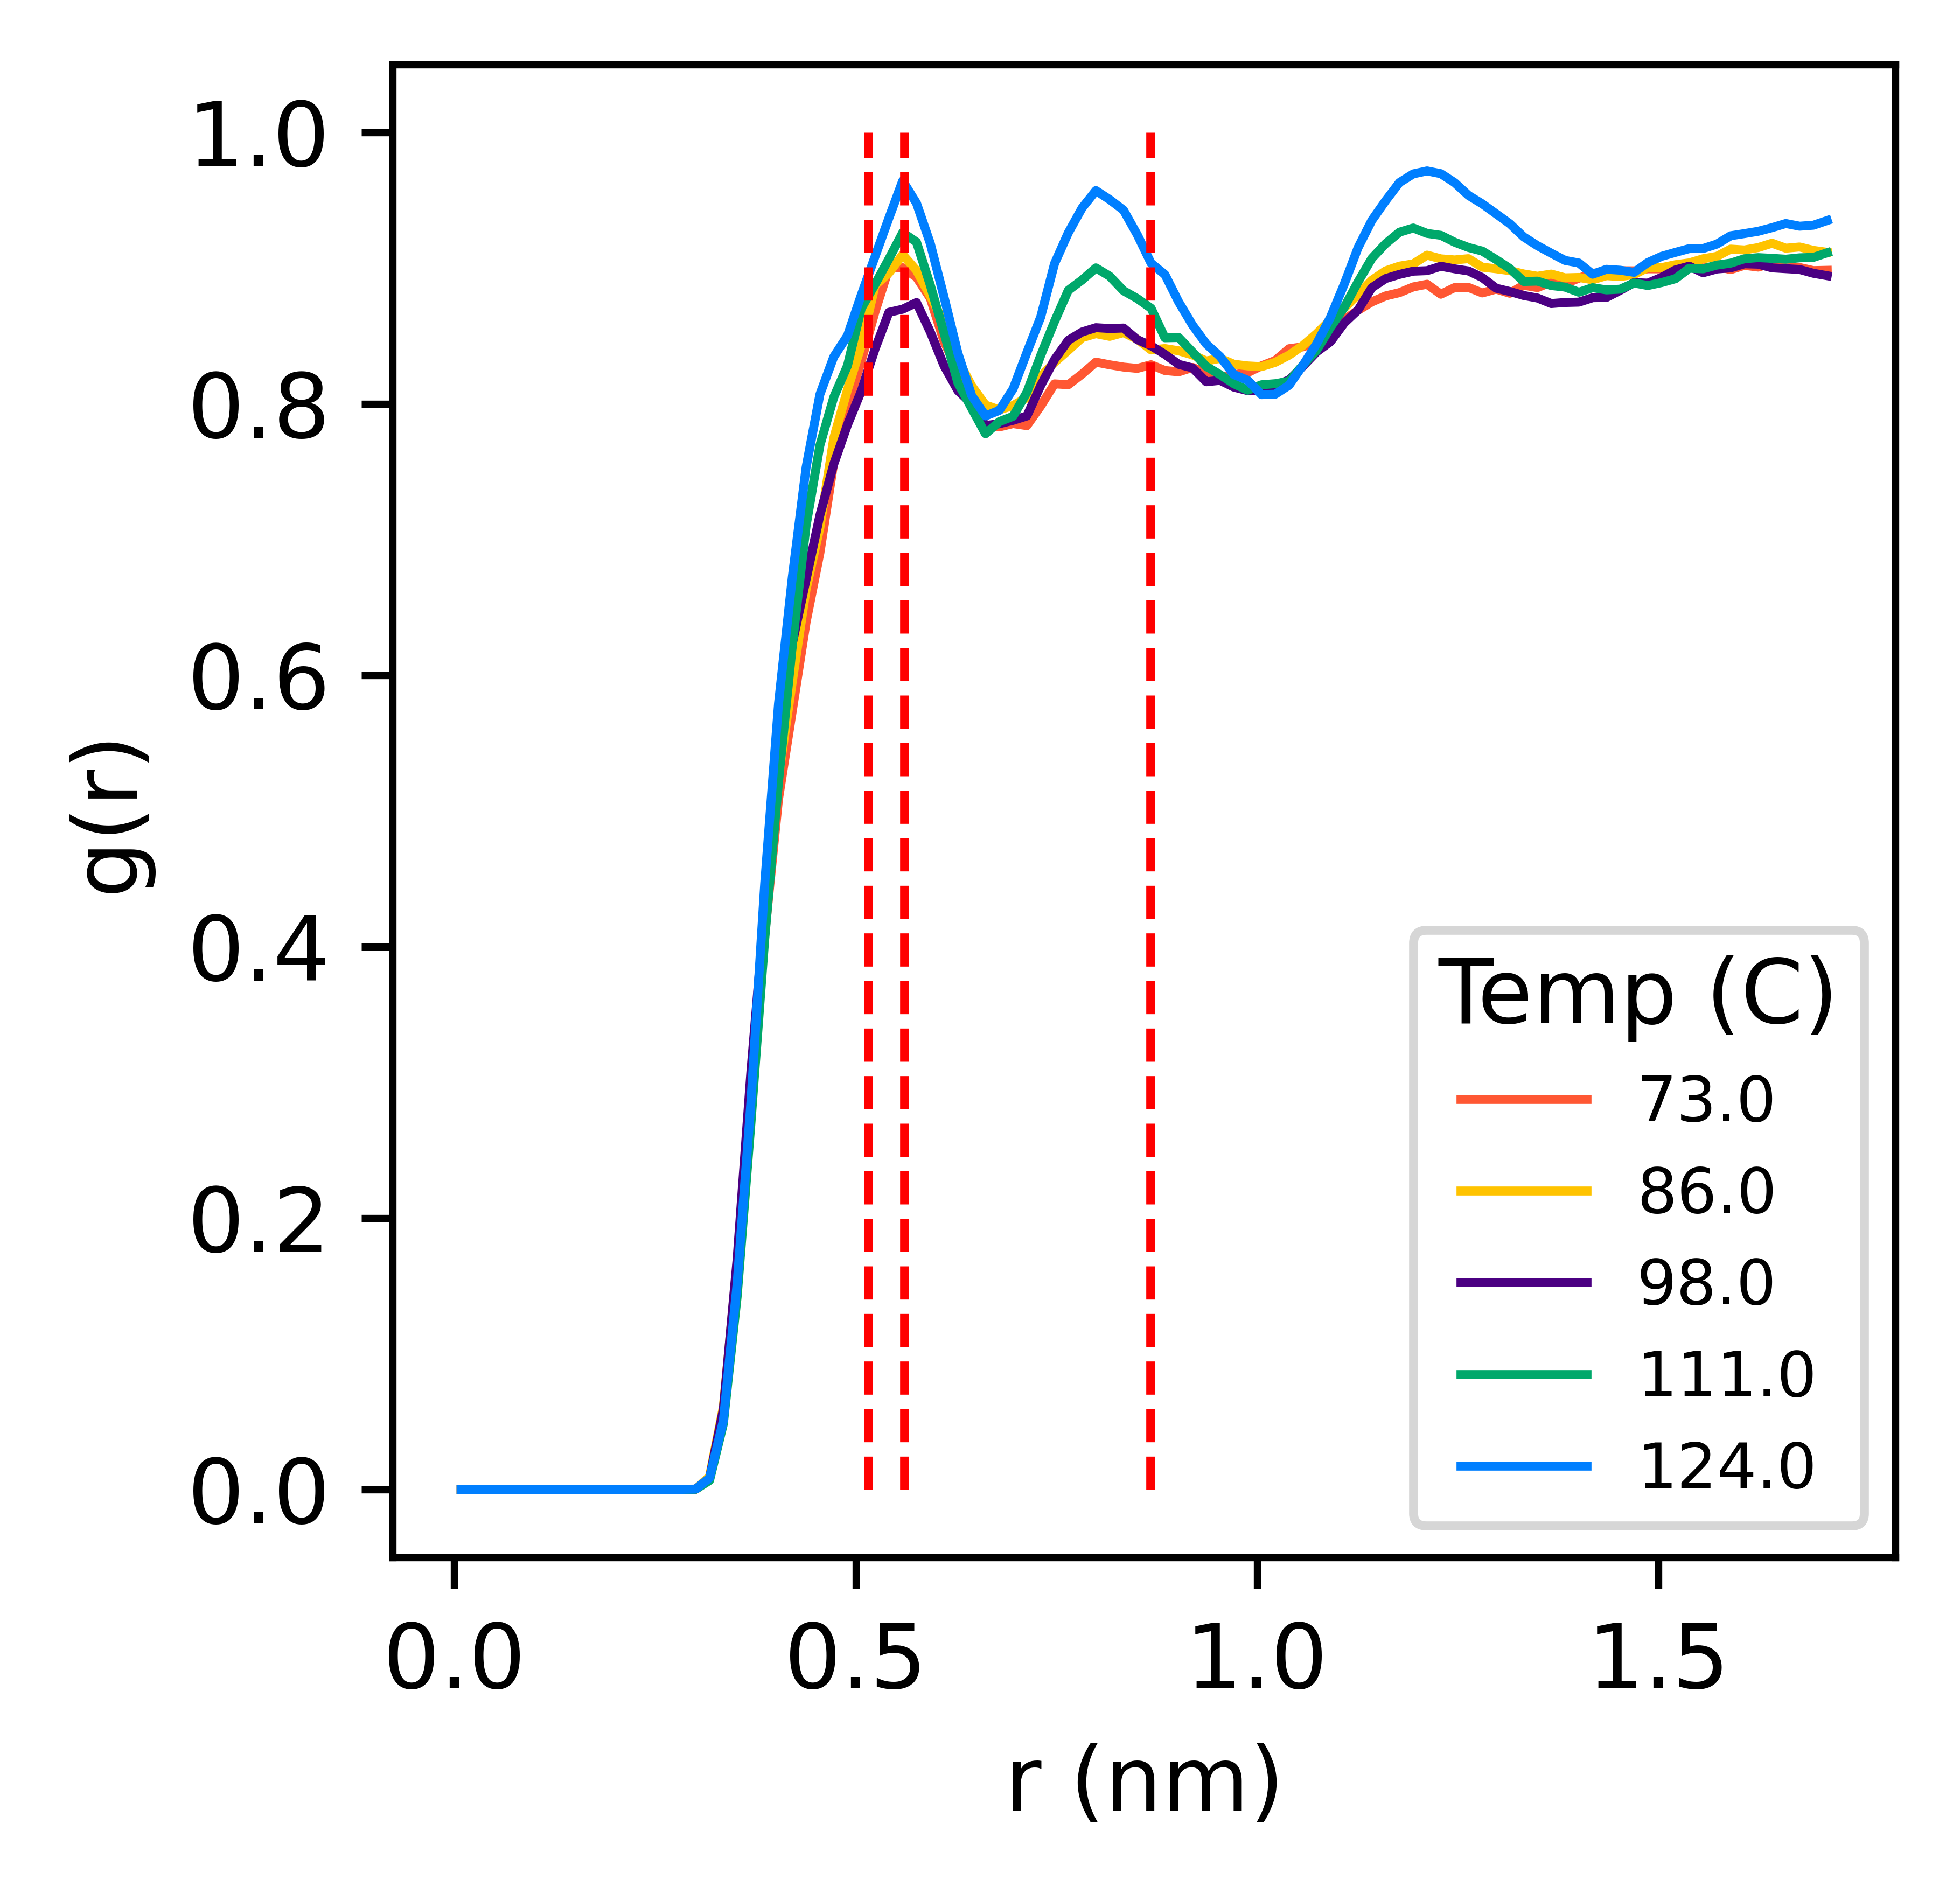

In [11]:
count = 0

for kT, jobs in project.find_jobs(
    {
        #"doc.npt_equilibrated": False,
         "sigma_scale": 0.955
    }
).groupby("kT"):
    if kT not in [2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4]:
        continue
    for job in jobs:

        print()
        if not job.isfile("cg_rdf.txt"):
            continue
        print(np.round(kT_to_T(job.sp.kT, epsilon=1065), 0))
        print(job.path)
        data = np.loadtxt(job.fn("cg_rdf.txt"))
        plt.plot(
            data[:,0] * job.doc.ref_length, data[:,1] + count * 0.00,
            label=np.round(kT_to_T(job.sp.kT, epsilon=1065), 0),
            c=colors[count]
        )
        count += 1

plt.vlines(x=0.561, ymin=0, ymax=1.0, linestyles="--", colors="r")
plt.vlines(x=0.516, ymin=0, ymax=1.0, linestyles="--", colors="r")
plt.vlines(x=0.867, ymin=0, ymax=1.0, linestyles="--", colors="r")
plt.legend(title="Temp (C)")
plt.ylabel("g(r)")
plt.xlabel("r (nm)")

# Structure Factors:

In [ ]:
count = 0

for kT, jobs in project.find_jobs({"sigma_scale": 0.955}).groupby("kT"):
    if kT < 2.0: continue
    for job in jobs:
        fpath = job.fn("last-npt-cg.gsd")
        sf = structure_factor(gsdfile=fpath, k_min=0.5, k_max=25, start=-10, stop=-1, ref_length=None)
        x = sf.bin_centers
        y = sf.S_k
        plt.plot(x, y+(count*0.25), label=kT, c=colors[count])
        count += 1

plt.legend(loc="right")

In [ ]:
for kT, jobs in project.find_jobs({"sigma_scale": 0.955}).groupby("kT"):
    if kT < 2.0: continue
    for job in jobs:
        fig = plt.figure()
        fpath = job.fn(f"cg-npt.gsd")
        sf = structure_factor(gsdfile=fpath, k_min=0.5, k_max=20, start=-10, stop=-1, ref_length=None)
        x = sf.bin_centers
        y = sf.S_k
        plt.plot(x, y, label=kT, c=colors[count])
        plt.title(f"kT: {kT}")
        plt.show()
        print()

In [ ]:
for kT, jobs in project.find_jobs({"sigma_scale": 0.955}).groupby("kT"):
    if kT < 2.0: continue
    for job in jobs:
        print(kT, job.path)

In [ ]:
for kT, jobs in project.find_jobs(
    {"doc.nvt_equilibrated": True,
     "sigma_scale": 0.955,
     "kT": 2.4,
     }).groupby("kT"):
    for job in jobs:
        #if not job.isfile("ua_structure_factor.txt"):
        fpath = job.fn(f"trajectory-nvt{job.doc.nvt_runs-1}.gsd")
        sf = structure_factor(gsdfile=fpath, k_min=0.5, k_max=30, start=-50, stop=-1, ref_distance=None)
        x = sf.bin_centers
        y = sf.S_k
        save_data = np.vstack([sf.bin_centers, sf.S_k]).T
        np.savetxt(job.fn("ua_structure_factor.txt"), save_data)
        #if not job.isfile("cg_structure_factor.txt"):
        cg_fpath = job.fn("cg-nvt.gsd")
        cg_sf = structure_factor(gsdfile=cg_fpath, k_min=0.5, k_max=30, start=-50, stop=-1, ref_distance=None)
        x = cg_sf.bin_centers
        y = cg_sf.S_k
        save_data = np.vstack([cg_sf.bin_centers, cg_sf.S_k]).T
        np.savetxt(job.fn("cg_structure_factor.txt"), save_data)
        #job.doc.sf_sampled = True

In [ ]:
plt.plot(sf.bin_centers, sf.S_k, label=kT)

In [ ]:
for kT, jobs in project.find_jobs({"doc.nvt_equilibrated": True, "sigma_scale": 0.955}).groupby("kT"):
    for job in jobs:
        fig = plt.figure()
        sf = np.loadtxt(job.fn("ua_structure_factor.txt"))
        plt.plot(sf[:,0], sf[:,1], label=kT)
        plt.legend()
        plt.show()

#plt.legend()
#plt.ylim(0, 4)
#plt.show()

# Diffraction Patterns:

In [ ]:
job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    "kT": 3.0,
    "doc.npt_equilibrated": False,
    "sigma_scale": 0.955
}
for job in project.find_jobs(filter=job_filter):
    print(job)

In [ ]:
views = get_quaternions(n_views=12)

In [ ]:
job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    "kT": 3.1,
    "doc.npt_equilibrated": False,
    "sigma_scale": 0.955
}

for job in project.find_jobs(filter=job_filter):
    print(job.path)
    dp = diffraction_pattern(
        gsdfile=job.fn("trajectory-npt20.gsd"),
        views=views,
        start=-20,
        stop=-1,
    )

In [ ]:
dp.plot()

In [ ]:
views = get_quaternions(n_views=4)

In [ ]:
run = 25

pic_count = 0

for i in range(1, 26):
    gsdfile = job.fn(f"trajectory-npt{i}.gsd")
    with gsd.hoomd.open(gsdfile) as traj:
        num_frames = len(traj)
        print(i, num_frames)
    for j in range(10, num_frames-10, 10):
        dp = diffraction_pattern(
            gsdfile=job.fn(f"trajectory-npt{i}.gsd"),
            views=[views[1]],
            start=j-10,
            stop=j
        )
        dp.plot().figure.savefig(f"images/dp{pic_count}.png")
        pic_count += 1

In [ ]:
dp.plot().figure.savefig("test.png")

In [ ]:
job.doc.npt_runs

In [ ]:
movie_maker(file_dir="images/", img_file_type="png", mov_file_name="pps_diff.mp4", framerate=80)